# Сегментация космических объектов




## Загрузка данных

Данные хранятся в гугл диске — https://drive.google.com/drive/u/0/folders/1Q1wR9aBFCyeFEYa3wwyXNu9wk_fZdzUm

Для быстрой загрузки данных достаточно добавить ярлык папки Final_dataset в свой диск.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/Final_dataset

all_bbox.txt  images  mask  ReadMe.txt


In [3]:
images_path = 'drive/MyDrive/Final_dataset/images/'
masks_path = 'drive/MyDrive/Final_dataset/mask/'

# images_path = '/kaggle/input/spacecraft-segmentation/images/'
# masks_path = '/kaggle/input/spacecraft-segmentation/mask/'

## Импорт библиотек

Загрузка на google colab

In [4]:
!pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/107.7 GB disk)


Загрузка для Kaggle — оставил для сравнения железок.

In [ ]:
# !pip install ultralytics

# import ultralytics
# ultralytics.checks()

Ultralytics YOLOv8.2.46 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5689.3/8062.4 GB disk)


In [5]:
import os
import ast

import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

import cv2
import torch
import shutil

import matplotlib.pyplot as plt

## Знакомство с данными

Выведем содержимое README-файла — там важная информация о данных.

In [7]:
with open(
    '/content/drive/MyDrive/Final_dataset/ReadMe.txt',
    # '/kaggle/input/spacecraft-segmentation/ReadMe.txt',
    'r'
    ) as readme_file:
    readme_text = readme_file.read()
    print(readme_text)

#A satellite dataset for object detection and segmentation using both synthesis and real satellite images.

#This dataset include 3116 images, mask with size 1280x720 and bounding boxes of both synthesis and real satellite images. Each satellite is segmented into at most 3 parts, including body, solar panel and antena by respectively 3 color: green,red,blue.

#Image with index 0-1002 has fine mask while images from index 1003-3116 has coarse masks.
The datasets is divided into 2 parts: train data including 403 fine mask from index 0-402 and 2114 coarse mask from index 1003-3116. The val dataset includes 600 images with fine mask indexed from 403 to 1002.

#File all_bbox.txt include bounding boxes of all satellites inside datasets based on segmentation masks in form of a dictionary with index of images as key. Each bounding boxes has format [max_x,max_y,min_x,min_y].



Что ж, удостоверимся в объявленных характеристиках датасета.

In [8]:
train_imgs_lst = os.listdir(images_path + 'train')
valid_imgs_lst = os.listdir(images_path + 'val')

ttl_num_of_imgs = len(train_imgs_lst) + len(valid_imgs_lst)

print(f'This dataset include {ttl_num_of_imgs} images.')
print(f'Train data including {len(train_imgs_lst)} images.')
print(f'Valid data including {len(valid_imgs_lst)} images.')
print()

train_msks_lst = os.listdir(masks_path + 'train')
valid_msks_lst = os.listdir(masks_path + 'val')
ttl_num_of_msks = len(train_msks_lst) + len(valid_msks_lst)

print(f'This dataset include {ttl_num_of_msks} masks.')
print(f'Train data including {len(train_msks_lst)} masks.')
print(f'Valid data including {len(valid_msks_lst)} masks.')

This dataset include 3119 images.
Train data including 2518 images.
Valid data including 601 images.

This dataset include 3117 masks.
Train data including 2517 masks.
Valid data including 600 masks.


Число изображений может быть подсчитано с ошибкой (в google colab), потому что в папках лежали файлы метаданных MacOS:

In [9]:
for filename in train_imgs_lst:
    if 'img' not in filename:
        print(filename)

.DS_Store


Удалим этот файл из списков:

In [10]:
train_imgs_lst.remove('.DS_Store')
valid_imgs_lst.remove('.DS_Store')

print(f'Train data including {len(train_imgs_lst)} images.')
print(f'Valid data including {len(valid_imgs_lst)} images.')

Train data including 2517 images.
Valid data including 600 images.


Восстановим словарь из текстового документа с информацией об ограничивающих рамках.

In [11]:
with open(
    '/content/drive/MyDrive/Final_dataset/all_bbox.txt',
    # '/kaggle/input/spacecraft-segmentation/all_bbox.txt',
    'r'
    ) as bboxes_file:
    bboxes = bboxes_file.read()
    bboxes_dict = ast.literal_eval(bboxes)

print('-'*40)
for i in range(3):
    k = list(bboxes_dict.keys())[i]
    v = bboxes_dict[list(bboxes_dict.keys())[i]]
    print(f'Image idx: {k}')
    print('Image bboxes:', *v, sep='\n')
    if i != 2:
        print()
print('-'*40, '\n')
print(f'Number of images in the dataset: {len(bboxes_dict)}')

objects_num = sum([len(lst) for lst in list(bboxes_dict.values())])

print(f'Number of objects in the dataset: {objects_num}')

bboxes_df = pd.DataFrame(
    bboxes_dict.items(), columns=['img_idx', 'bboxes']
    )
bboxes_df['num_of_bboxes_in_img'] = bboxes_df['bboxes'].apply(lambda x: len(x))
bboxes_df.num_of_bboxes_in_img.value_counts()

----------------------------------------
Image idx: 1003
Image bboxes:
[1142.0, 547.0, 296.0, 135.0]

Image idx: 1004
Image bboxes:
[728.0, 198.0, 542.0, 59.0]
[212.0, 305.0, 0.0, 118.0]
[1279.0, 437.0, 768.0, 85.0]

Image idx: 1005
Image bboxes:
[1214.0, 582.0, 322.0, 32.0]
---------------------------------------- 

Number of images in the dataset: 3117
Number of objects in the dataset: 3670


num_of_bboxes_in_img
1     2757
2      250
3       63
4       30
5        9
6        3
8        2
7        2
11       1
Name: count, dtype: int64

Большая часть изображений содержит лишь одну ограничивающую рамку, к чему при беглом осмотре масок должны быть вопросы, т.к. чаще всего встречаются аппараты с солнечными панелями. Вероятно, ограничивающие рамки, которыми снабдили нас авторы датасета, относятся к аппарату в целом.

В этой тетрадке мы обучим YOLOv8 решать задачу сегментации изображений космических аппаратов, и оригинальные ограничивающие рамки нам здесь не понадобятся.

Напишем функцию для вывода примеров изображений с масками прямо из папок.

In [12]:
def get_img_msk_vis(img_name: str, sample='train'):
    imgs_smpl_path = images_path + sample
    msks_smpl_path = masks_path + sample

    if img_name not in os.listdir(imgs_smpl_path):
        print('Нет изображения с таким именем')
        return None

    img_path = imgs_smpl_path + '/' + img_name
    msk_path = msks_smpl_path + '/' + img_name.split('.')[0] + '_mask.png'

    img = plt.imread(img_path)
    msk = plt.imread(msk_path)
    # Создаем фигуру и координатную плоскость
    fig, ax = plt.subplots(1, 2, figsize=(16, 12))
    # Выводим изображение на экран
    ax[0].imshow(img)
    ax[1].imshow(msk)
    plt.show()

img_resize_2579.png


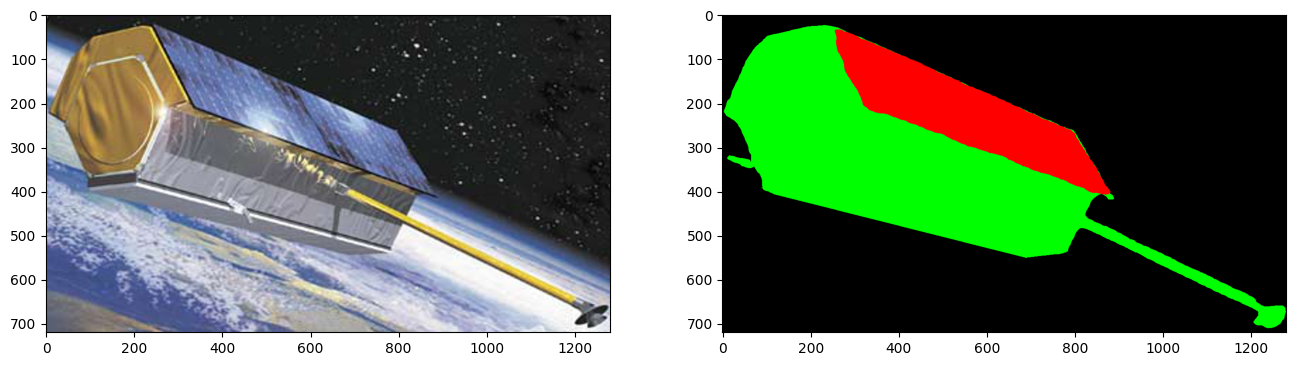

img_resize_720.png


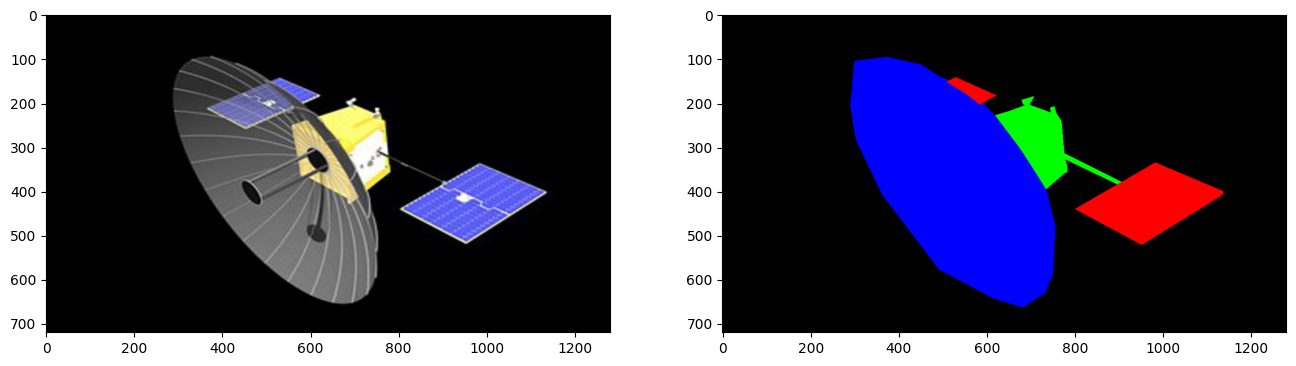

In [ ]:
# Выберем случайные изображения и выведем их в паре с масками
random_image_filename = np.random.choice(train_imgs_lst)
print(random_image_filename)
get_img_msk_vis(random_image_filename)
# ...и для валидационной выборки
random_image_filename = np.random.choice(valid_imgs_lst)
print(random_image_filename)
get_img_msk_vis(random_image_filename, sample='val')

## Подготовка датасета

Согласно [документации ultralytics](https://docs.ultralytics.com/datasets/segment/), нам нужно подготовить для каждого изображения текстовый файл аннотаций с указанием классов объектов и координат их границ, что при наличии цветовых масок не является нетривиальной задачей.

Хотя ultralytics имеет инструментарий для автоматического аннотирования, наш датасет он с наскока не возьмет, т.к. предобучен на данных COCO и т.п. Поэтому мы воспользуемся старым добрым opencv.

In [13]:
def find_figures_boundaries(orig_mask):
    # Преобразуем изображение в формат HSV для
    # лучшего выделения цветовых масок
    hsv = cv2.cvtColor(orig_mask, cv2.COLOR_BGR2HSV)
    height, width = hsv.shape[:2]
    # Определяем цветовые диапазоны для красного, зеленого и синего
    # и заодно перекодируем классы
    color_ranges = {
        # red | solar panel
        0: [
            (0, 100, 100), (10, 255, 255),
            (160, 100, 100), (180, 255, 255)
            ],
        # green | body
        1: [(40, 100, 100), (80, 255, 255)],
        # blue | antenna
        2: [(100, 100, 100), (140, 255, 255)]
    }

    figures_boundaries = []

    for color, ranges in color_ranges.items():
        mask = None
        # Создаем маску для соответствующего цветового диапазона
        for (lower, upper) in zip(ranges[0::2], ranges[1::2]):
            lower_bound = np.array(lower, dtype=np.uint8)
            upper_bound = np.array(upper, dtype=np.uint8)
            if mask is None:
                mask = cv2.inRange(hsv, lower_bound, upper_bound)
            else:
                mask |= cv2.inRange(hsv, lower_bound, upper_bound)

        # Поиск контуров фигур на маске
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
            )

        for contour in contours:
            # epsilon = 0.01 * cv2.arcLength(contour, True)
            # approx_contour = cv2.approxPolyDP(contour, epsilon, True)

            figure_boundary = []
            figure_boundary.append(color)
            # for point in approx_contour:
            for point in contour:
                x, y = point.ravel()
                x /= width
                y /= height
                figure_boundary.extend([x, y])

            figures_boundaries.append(figure_boundary)

    return figures_boundaries


def get_boundaries_list(
    list_of_masks_names=train_msks_lst,
    sample='train/'
    ):

    all_boundaries_list = []

    for mask_name in tqdm(list_of_masks_names):
        # Путь до маски
        mask_path = masks_path + sample + mask_name
        # Загрузим маску
        orig_mask = cv2.imread(mask_path)

        # Найдем границы объектов
        boundaries = find_figures_boundaries(orig_mask)
        # Закинем границы в общий список
        all_boundaries_list.append(boundaries)

    return all_boundaries_list

Протестируем наш код для получения аннотаций.

100%|██████████| 4/4 [00:02<00:00,  1.34it/s]



Число масок: 4

В маске №1 число объектов: 25
'0': 4
'1': 21
В маске №2 число объектов: 12
'0': 3
'1': 9
В маске №3 число объектов: 4
'0': 2
'1': 2
В маске №4 число объектов: 9
'0': 1
'1': 8



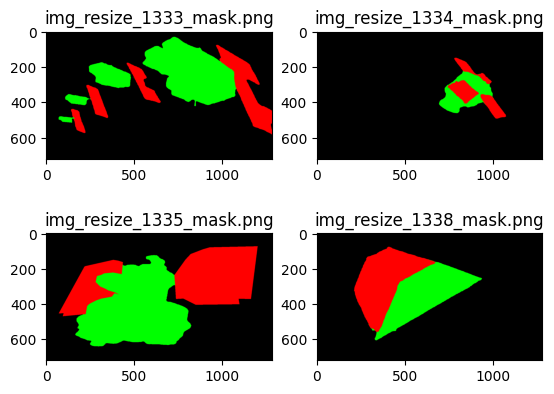

In [14]:
def get_trial_boundaries_list(msks_lst, sample_size=4, sample='train/'):

    trial_boundaries_list = get_boundaries_list(
        msks_lst[:sample_size], sample=sample
        )

    print(f'\nЧисло масок: {sample_size}\n')
    for i, boundaries in enumerate(trial_boundaries_list):
        print(f'В маске №{i+1} число объектов: {len(boundaries)}')
        colors = []
        for j in range(len(boundaries)):
            colors.append(boundaries[j][0])
        occurrences = Counter(colors)
        for color, count in occurrences.items():
            print(f"'{color}': {count}")

    print()
    plt.figure()
    for i, mask_name in enumerate(msks_lst[:sample_size]):
        masks_smpl_path = masks_path + sample
        mask_path = masks_smpl_path + '/' + mask_name
        msk = plt.imread(mask_path)
        plt.subplot(221 + i)
        plt.imshow(msk)
        plt.title(mask_name)

get_trial_boundaries_list(train_msks_lst)

Странновато выглядит, конечно, но этому есть объяснение.

100%|██████████| 4/4 [00:02<00:00,  1.51it/s]



Число масок: 4

В маске №1 число объектов: 4
'0': 2
'1': 1
'2': 1
В маске №2 число объектов: 3
'0': 1
'1': 2
В маске №3 число объектов: 3
'0': 2
'1': 1
В маске №4 число объектов: 1
'1': 1



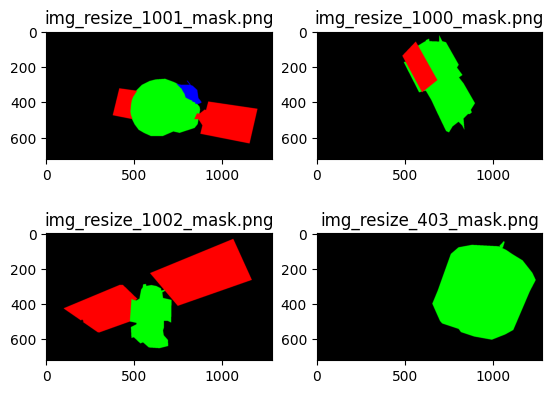

In [15]:
get_trial_boundaries_list(valid_msks_lst, sample='val/')

Вот мы и лицезрели объявленную особенность масок: изображения с индексами из интервала 0–1002 имеют качественную маску, а изображения с индексами 1003–3116 — грубую. Поэтому число объектов в масках треннировочной выборки не совпадает с выявленным числом контуров в них.

Думаю, особенных проблем это нам не доставит, и мы можем приступать к аннотированию с тем, что имеется на данный момент.

Сперва создадим директории. Зададим пути в виде глобальных переменных.

In [ ]:
# DATA_PATH = "dataset/"
DATA_PATH = '/kaggle/working/dataset/'
LABELS_PATH = os.path.join(DATA_PATH, "labels")
IMGS_PATH = os.path.join(DATA_PATH, "images")

TRAIN_IMAGES_PATH = os.path.join(IMGS_PATH, "train")
VAL_IMAGES_PATH = os.path.join(IMGS_PATH, "val")
TRAIN_LABELS_PATH = os.path.join(LABELS_PATH, "train")
VAL_LABELS_PATH = os.path.join(LABELS_PATH, "val")

DATA_CONFIG_PATH = os.path.join(DATA_PATH, "dataset.yaml")

print(TRAIN_IMAGES_PATH)
print(VAL_IMAGES_PATH)
print(TRAIN_LABELS_PATH)
print(VAL_LABELS_PATH)
print(DATA_CONFIG_PATH)

/kaggle/working/dataset/images/train
/kaggle/working/dataset/images/val
/kaggle/working/dataset/labels/train
/kaggle/working/dataset/labels/val
/kaggle/working/dataset/dataset.yaml


In [ ]:
# Создаем локальную папку, в которую будем складывать изображения
# и аннотации к ним (если таковой еще не существует)
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Создаем папку, где будем хранить тренировочные изображения
# (если такая еще не существует)
if not os.path.exists(TRAIN_IMAGES_PATH):
    os.makedirs(TRAIN_IMAGES_PATH)
# Создаем папку, где будем хранить тренировочные аннотации к объектам
# (если такая еще не существует)
if not os.path.exists(TRAIN_LABELS_PATH):
    os.makedirs(TRAIN_LABELS_PATH)

# Создаем папку, где будем хранить валидационные изображения
# (если такая еще не существует)
if not os.path.exists(VAL_IMAGES_PATH):
    os.makedirs(VAL_IMAGES_PATH)

# Создаем папку, где будем хранить валидационные аннотации к объектам
# (если такая еще не существует)
if not os.path.exists(VAL_LABELS_PATH):
    os.makedirs(VAL_LABELS_PATH)

Добавим файл конфигурации данных, назовем его - dataset.yaml, в нем пропишем все пути.

In [ ]:
labels_dict = {
    0: 'solar_panel', 1: 'body', 2: 'antenna'
    }

color_dict = {
    0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255)
}

names = '\n    '.join(
    [f'{k}: {v}' for k, v in labels_dict.items()]
)

# Создаем содержимое файла
data_config = f'''
path: {DATA_PATH}
train: images/train
val: images/val
test:
names:
    {names}
'''

# Открываем на запись файл, куда записываем конфигурацию путей,
# откуда будут браться данные для обучения
with open(DATA_CONFIG_PATH, 'w') as f:
    f.write(data_config)

# Проверим, что все записалось корректно
with open(DATA_CONFIG_PATH, 'r') as f:
    print(f.read())


path: /kaggle/working/dataset/
train: images/train
val: images/val
test:
names:
    0: solar_panel
    1: body
    2: antenna



Получим списки координат границ для масок из каждой выборки.

In [ ]:
train_boundaries_list = get_boundaries_list(
    list_of_masks_names=train_msks_lst, sample='train/'
    )

valid_boundaries_list = get_boundaries_list(
    list_of_masks_names=valid_msks_lst, sample='val/'
    )

100%|██████████| 600/600 [00:29<00:00, 20.19it/s]


Напишем функцию для записи аннотаций и копирования изображений в рабочую директорию.

In [ ]:
def get_annots_rec(msks_lst, boundaries_list, path2save='train'):
    # Создаем цикл по маскам
    for i, filename in enumerate(tqdm(msks_lst)):
        # Составляем путь до файла, куда запишем новую аннотацию
        new_annotation_path = os.path.join(
            LABELS_PATH, path2save, filename[:-9] + ".txt"
            )
        # Открываем на запись с добавлением (w+) файл формата .txt
        with open(new_annotation_path, 'w+') as f:
            boundaries = boundaries_list[i]
            # Построчно записываем координаты каждого контура
            for j in range(len(boundaries)):
                text = ' '.join(list(map(str, boundaries[j])))
                f.write(text)
                f.write("\n")
        # Переносим в новую папку изображения из исходной папки
        img_name = filename[:-9] + ".png"
        shutil.copy(
            os.path.join(images_path, path2save, img_name),
            os.path.join(IMGS_PATH, path2save, img_name)
        )

    return


In [ ]:
get_annots_rec(train_msks_lst, train_boundaries_list, path2save='train')

100%|██████████| 2517/2517 [00:46<00:00, 54.18it/s]


In [ ]:
get_annots_rec(valid_msks_lst, valid_boundaries_list, path2save='val')

100%|██████████| 600/600 [00:12<00:00, 49.44it/s]


Проверим файлы

In [ ]:
print(sorted(os.listdir(TRAIN_LABELS_PATH))[:5])
print(sorted(os.listdir(TRAIN_IMAGES_PATH))[:5])

['img_resize_0.txt', 'img_resize_1.txt', 'img_resize_10.txt', 'img_resize_100.txt', 'img_resize_1003.txt']
['img_resize_0.png', 'img_resize_1.png', 'img_resize_10.png', 'img_resize_100.png', 'img_resize_1003.png']


Отрисуем пример сегментированного изображения согласно добытым аннотациям.

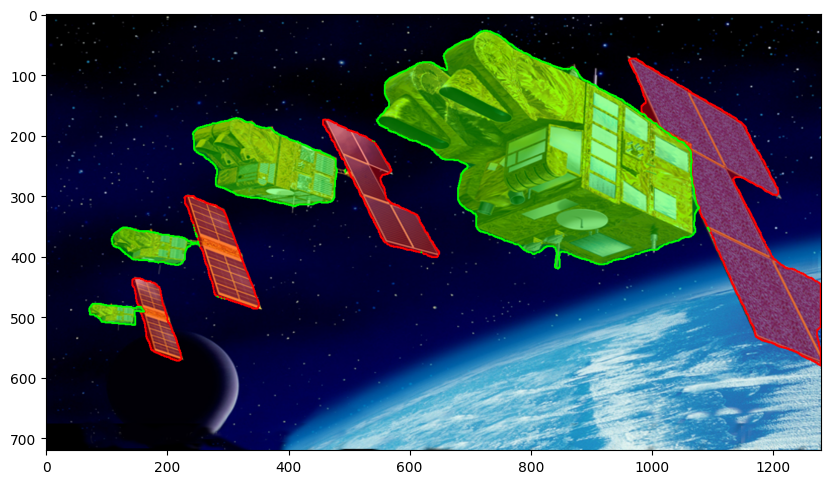

In [ ]:
def visualize_segmentation(image_path, annotation_path):
    """
    Визуализация аннотаций сегментации на изображении.

    :param image_path: Путь до изображения
    :param annotation_path: Путь до текстового файла с аннотациями
    """
    # Считываем изображение
    image = cv2.imread(image_path)
    # Конвертируем из BGR в RGB для корректного отображения
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Читаем аннотации
    with open(annotation_path, 'r') as file:
        annotations = file.readlines()

    for annotation in annotations:
        # Разделяем строку по пробелам
        # (первый элемент - класс, остальные - координаты)
        data = annotation.split()
        class_id = int(data[0])
        coords = np.array(data[1:]).astype(np.float32).reshape(-1, 2)

        # Преобразуем нормализованные координаты в пиксели
        coords[:, 0] *= width
        coords[:, 1] *= height
        coords = coords.astype(np.int32)

        # Рисуем границы объекта (Polygon)
        cv2.polylines(
            image, [coords], isClosed=True,
            color=color_dict[class_id], thickness=2
            )

        # Полупрозрачный многоугольник
        overlay = image.copy()
        alpha = 0.4  # Прозрачность

        # Закрашиваем область на копии изображения
        cv2.fillPoly(overlay, [coords], color=color_dict[class_id])

        # Добавляем полупрозрачный многоугольник к исходному изображению
        cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    # Отображение изображения с аннотациями
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.show()

# Пример использования
image_path = '/kaggle/working/dataset/images/train/img_resize_1333.png'
annotation_path = '/kaggle/working/dataset/labels/train/img_resize_1333.txt'
visualize_segmentation(image_path, annotation_path)

Ранее именно для этого изображения мы наблюдали неадекватно большое число обнаруенных контуров для body. И здесь мы видим, что действительно имеются точки и маленькие участки зеленого цвета на солнечных панелях: признак некачественной маски.

In [ ]:
# Проверим, что количество аннотаций совпадает с количество изображений в каждой выборке
print(len(os.listdir(TRAIN_LABELS_PATH)) == len(os.listdir(TRAIN_IMAGES_PATH)))
print(len(os.listdir(VAL_LABELS_PATH)) == len(os.listdir(VAL_IMAGES_PATH)))

True
True


## Строим модель сегментации

Для сохранения процесса обучения воспользуемся инструментом Weights&Bias. Авторизуемся через анонимный аккаунт.

In [ ]:
!pip install -q wandb --upgrade

import wandb
wandb.login(anonymous='must')

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Обучаем модель

Теперь мы можем воспользоваться модель и дообучить ее под нашу задачу.

In [ ]:
# from ultralytics import YOLO

# # Load a model
# model = ultralytics.YOLO("yolov8m-seg.pt") # load a pretrained model

# # Train the model
# train_result = model.train(
#     data="/kaggle/working/dataset/dataset.yaml",
#     batch=-1, epochs=60, imgsz=640,
#     workers=os.cpu_count()
#     )

После обучения закомментим код, чтобы убрать ковер логов. Отметим лишь также, что на эпоху при обучении данной модели уходит почти три минуты.

### Валидируем модель

Посмотрим на графики, наиболее общая информация, представляющая для нас интерес содержится в файле results.png.

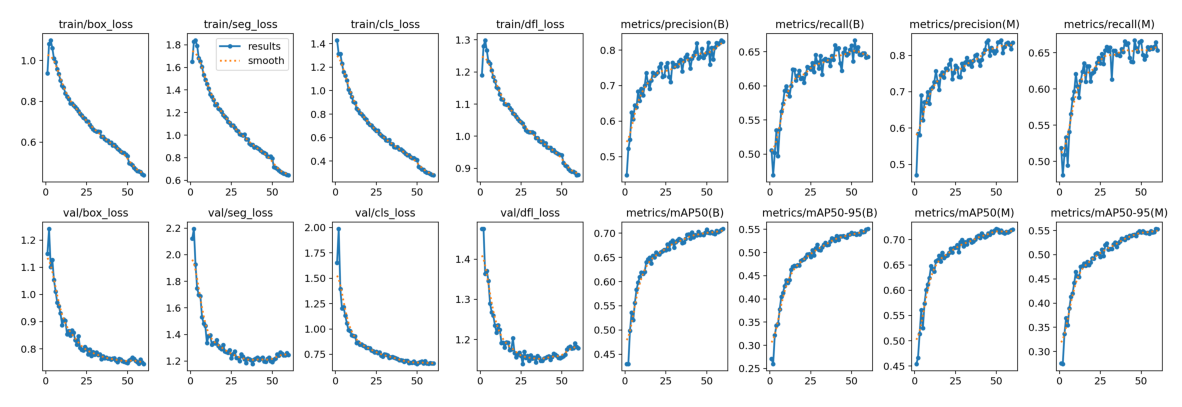

In [ ]:
# Читаем файл с графиками процесса обучения
# results = plt.imread('/content/runs/segment/train/results.png')
results = plt.imread('/kaggle/working/runs/segment/train2/results.png')
# Отображаем графики
fig, ax = plt.subplots(figsize=(15,12))
ax.axis('off')
ax.imshow(results);

В папке runs/detect/train/weights хранятся 2 файла с весами (параметрами нейронной сети):

* best.pt — файл, в котором сохранен лучший вариант параметров модели за все время обучения
* last.pt — файл, в котором сохранены веса, которые модель получила на последней эпохе обучения

In [ ]:
# os.listdir('/content/runs/segment/train/weights/')
os.listdir('/kaggle/working/runs/segment/train2/weights/')

['last.pt', 'best.pt']

Загрузим наилучшие веса в нашу модель и выведем метрики для валидационной выборки.

In [ ]:
# model = ultralytics.YOLO("/content/runs/segment/train/weights/best.pt")
model = ultralytics.YOLO("/kaggle/working/runs/segment/train2/weights/best.pt")
# Validate the model
results = model.val()  # no arguments needed, dataset and settings remembered
results.box.map  # map50-95
results.box.map50  # map50
results.box.map75  # map75
results.box.maps  # a list contains map50-95 of each category

Ultralytics YOLOv8.2.46 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv8m-seg summary (fused): 245 layers, 27224121 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/dataset/labels/val.cache... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.72it/s]


                   all        600       2689      0.824      0.643      0.709      0.551      0.834      0.653      0.719      0.551
           solar_panel        532       1206      0.884      0.831      0.881      0.747      0.887      0.837      0.889      0.761
                  body        600       1106      0.841      0.577      0.611      0.446       0.86      0.592      0.624      0.443
               antenna        195        377      0.746       0.52      0.634       0.46      0.755      0.531      0.646      0.451
Speed: 0.2ms preprocess, 8.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/val


array([    0.74682,     0.44625,     0.45984])

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Займемся составлением таблицы предсказаний модели.

In [ ]:
# # Создаем пустой список
# preds_lst = []
# # Создаем цикл по всем файлами
# for filename in tqdm(valid_imgs_lst):
#     # Составляем путь до изображения
#     image_path = os.path.join(VAL_IMAGES_PATH, filename)
#     # Пропускаем изображение через модель
#     prediction = model.predict(image_path)
#     # Конвертируем предсказания в список
#     pred_rows = prediction[0].boxes.data.tolist()
#     # Получаем список масок
#     masks_list = prediction[0].masks.xyn
#     # Проходимся циклом по предсказаниям и заносим их в список
#     for i in range(len(pred_rows)):
#         pred_lst = []
#         pred_lst.append(filename)
#         pred_lst.extend(pred_rows[i])
#         pred_lst.extend([masks_list[i]])
#         preds_lst.append(pred_lst)

In [16]:
# Загрузим ранее сохраненные датафреймы
preds_df = pd.read_csv('/content/preds_df.csv')
trues_df = pd.read_csv('/content/trues_df.csv')

In [17]:
# Собираем таблиццу
# columns = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'pred_class', 'pred_mask']
# preds_df = pd.DataFrame(data=preds_lst, columns=columns)
preds_df.head()

,filename,xmin,ymin,xmax,ymax,confidence,pred_class,pred_mask
0,img_resize_946.png,510.738159,172.082275,1114.862671,602.493164,0.962522,0.0,[[ 0.42031 0.23889]\n [ 0.42031 ...
1,img_resize_946.png,93.066101,50.350708,396.805664,303.603088,0.956462,0.0,[[ 0.09375 0.072222]\n [ 0.09375 0...
2,img_resize_946.png,304.447388,119.117615,554.899231,391.556335,0.935174,1.0,[[ 0.33437 0.16111]\n [ 0.33437 ...
3,img_resize_862.png,775.250732,170.848572,1066.034668,365.774780,0.953565,1.0,[[ 0.66875 0.23889]\n [ 0.66875 ...
4,img_resize_862.png,214.952698,297.443970,664.579468,542.520386,0.917867,1.0,[[ 0.38594 0.41667]\n [ 0.38594 ...


In [ ]:
#Сохраняем полученные предсказания
preds_df.to_csv('preds_df.csv', index=False)

In [18]:
# trues_lst = []
# for i, filename in enumerate(valid_msks_lst):
#     for j in range(len(valid_boundaries_list[i])):
#         true_lst = []
#         img_name = filename[:-9] + '.png'
#         true_lst.append(img_name)
#         true_lst.append(valid_boundaries_list[i][j][0])
#         true_lst.extend([valid_boundaries_list[i][j][1:]])
#         trues_lst.append(true_lst)

# # Собираем таблиццу
# columns = ['filename', 'true_class', 'orig_mask']
# trues_df = pd.DataFrame(data=trues_lst, columns=columns)
# #Сохраняем полученные предсказания
# trues_df.to_csv('trues_df.csv', index=False)
trues_df.head()

,filename,true_class,orig_mask
0,img_resize_796.png,0,"[0.7234375, 0.20972222222222223, 0.72265625, 0..."
1,img_resize_796.png,1,"[0.7140625, 0.0125, 0.71328125, 0.013888888888..."
2,img_resize_873.png,1,"[0.6140625, 0.3333333333333333, 0.61328125, 0...."
3,img_resize_567.png,0,"[0.7171875, 0.6291666666666667, 0.71640625, 0...."
4,img_resize_567.png,0,"[0.0, 0.0, 0.0, 0.001388888888888889, 0.0, 0.0..."


Что делает код:

1. **Функция `sutherland_hodgman_clip`**: Реализует нахождение пересечения двух многоугольников.
  - Реализует алгоритм Sutherland-Hodgman для нахождения пересечения двух многоугольников.
  - Использует вспомогательные функции `inside` и `intersection` для определения, лежит ли точка внутри отсекателя, и для нахождения пересечения двух ребер, соответственно.
2. **Функция `polygon_area`**: Вычисляет площадь многоугольника.
  - Вычисляет площадь многоугольника по его вершинам с использованием формулы площади.
3. **Функция `compute_union_area`**:
  - Вычисляет площадь объединения двух многоугольников как сумму их площадей за вычетом площади их пересечения.
4. **Функция `calculate_iou`**:
  - Находит пересечение и объединение двух многоугольников.
  - Использует площади пересечения и объединения для расчета IoU.

In [22]:
def sutherland_hodgman_clip(subject_polygon, clip_polygon):
    def inside(p, cp1, cp2):
        return (cp2[0] - cp1[0]) * (p[1] - cp1[1]) > (cp2[1] - cp1[1]) * (p[0] - cp1[0])

    def intersection(cp1, cp2, s, e):
        dc = cp1 - cp2
        dp = s - e
        n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
        n2 = s[0] * e[1] - s[1] * e[0]
        n3 = 1.0 / (dc[0] * dp[1] - dc[1] * dp[0])
        return torch.tensor([(n1 * dp[0] - n2 * dc[0]) * n3, (n1 * dp[1] - n2 * dc[1]) * n3])

    output_list = subject_polygon
    cp1 = clip_polygon[-1]

    for clip_vertex in clip_polygon:
        cp2 = clip_vertex
        input_list = output_list
        output_list = []

        if len(input_list) == 0:
            break

        s = input_list[-1]

        for subject_vertex in input_list:
            e = subject_vertex
            if inside(e, cp1, cp2):
                if not inside(s, cp1, cp2):
                    output_list.append(intersection(cp1, cp2, s, e))
                output_list.append(e)
            elif inside(s, cp1, cp2):
                output_list.append(intersection(cp1, cp2, s, e))
            s = e
        cp1 = cp2

    return output_list

def polygon_area(polygon):
    n = len(polygon)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += polygon[i][0] * polygon[j][1]
        area -= polygon[j][0] * polygon[i][1]
    area = abs(area) / 2.0
    return area

def compute_union_area(subject_polygon, clip_polygon):
    area_subject = polygon_area(subject_polygon)
    area_clip = polygon_area(clip_polygon)
    intersection_polygon = sutherland_hodgman_clip(subject_polygon, clip_polygon)
    area_intersection = polygon_area(intersection_polygon)
    union_area = area_subject + area_clip - area_intersection
    return union_area

def calculate_iou(subject_polygon, clip_polygon, eps=1e-7):
    intersection_polygon = sutherland_hodgman_clip(subject_polygon, clip_polygon)
    area_intersection = polygon_area(intersection_polygon)
    area_union = compute_union_area(subject_polygon, clip_polygon)
    iou = area_intersection / (area_union + eps)
    return iou

# Пример использования:
subject_polygon = torch.tensor([[0.2, 0.2], [0.4, 0.4], [0.2, 0.6], [0.0, 0.4]])
clip_polygon = torch.tensor([[0.0, 0.0], [0.0, 1.0], [0.5, 1.0], [0.5, 0.0]])

iou = calculate_iou(subject_polygon, clip_polygon)
print("IoU:", iou)

IoU: tensor(0.)


## Отчет модели

YOLOv8 хорош тем, что также при валидации самостоятельно сохраняет всю информацию в картинках:

In [ ]:
plt.subplots(figsize=(12, 12))
plt.imshow(plt.imread("yolov8_data/images/confusion_matrix.png"));

In [ ]:
plt.subplots(figsize=(12, 12))
plt.imshow(plt.imread("yolov8_data/images/confusion_matrix_normalized.png"));

In [ ]:
plt.subplots(figsize=(12, 12))
plt.imshow(plt.imread("yolov8_data/images/F1_curve.png"));

In [ ]:
plt.subplots(figsize=(12, 12))
plt.imshow(plt.imread("yolov8_data/images/P_curve.png"));

In [ ]:
plt.subplots(figsize=(12, 12))
plt.imshow(plt.imread("yolov8_data/images/R_curve.png"));

In [ ]:
plt.subplots(figsize=(12, 12))
plt.imshow(plt.imread("yolov8_data/images/PR_curve.png"));

In [ ]:
plt.subplots(figsize=(15, 15))
plt.imshow(plt.imread("yolov8_data/images/val_batch0_labels.jpg"));

In [ ]:
plt.subplots(figsize=(15, 15))
plt.imshow(plt.imread("yolov8_data/images/val_batch0_pred.jpg"));

In [ ]:
plt.subplots(figsize=(15, 15))
plt.imshow(plt.imread("yolov8_data/images/val_batch2_pred.jpg"));